# MCMC FAQ

This FAQ will cover several "advanced" topics that might come up in the context of doing MCMC with ``py21cmmc``. Throughout we will use the following imports:

In [2]:
from py21cmmc import mcmc, __version__
import logging

%matplotlib inline
import matplotlib.pyplot as plt

print("Using version ", __version__, " of 21CMMC.")

0.1.0


## How to Continue Running a Chain After it has Stopped?

``21CMMC`` has an inbuilt custom chain storage mechanism which uses ``h5py``. The storage class itself is found here:

In [2]:
from py21cmmc.mcmc.cosmoHammer.storage import HDFStorage

This class should not be required to be instantiated directly, however. In any case, this class has in-built mechanisms for detecting which iteration the chain is currently at, and saves the complete random state of the chain at each iteration. Thus, it can be started from wherever it stops (due to an exception, or walltime limits on a shared system). In practice, doing so is as easy as calling ``run_mcmc`` with the ``continue_sampling`` set to ``True`` (which it is by default). One just needs to ensure that the data directory and model name are consistent so that the previous chain can be located:

In [3]:
core = mcmc.CoreCoevalModule(
    redshift = 7.0,
    user_params = {"HII_DIM":40, "BOX_LEN":80.0}
)

likelihood = mcmc.Likelihood1DPowerCoeval(simulate=True) # require simulate=True to explicitly allow simulation

To see what is happening directly from the notebook, we're going to set the error level of the stream logger to INFO, so that the entire log file is also written to stdout:

In [4]:
mcmc.run_mcmc(
    core, likelihood, 
    params = {"HII_EFF_FACTOR":[30,20,40,3]},
    datadir='.', model_name='a_model',
    sampleIterations = 10,
    burninIterations = 0,
    walkersRatio = 2, 
    log_level_stream = logging.INFO,
    continue_sampling=False
);

Initializing init and perturb boxes for the entire chain... done.


2018-08-07 10:40:35,639 INFO:Using CosmoHammer 0.6.1
2018-08-07 10:40:35,639 INFO:Using emcee 2.2.1
2018-08-07 10:40:35,644 INFO:all burnin iterations already completed
2018-08-07 10:40:35,645 INFO:Sampler: <class 'py21cmmc.mcmc.cosmoHammer.CosmoHammerSampler.CosmoHammerSampler'>
configuration: 
  Params: [30]
  Burnin iterations: 0
  Samples iterations: 10
  Walkers ratio: 2
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.mcmc.cosmoHammer.storage.HDFStorageUtil object at 0x7f0955d2bc18>
likelihoodComputationChain: 
Core Modules: 
  CoreCoevalModule
Likelihood Modules: 
  Likelihood1DPowerCoeval

2018-08-07 10:40:35,646 INFO:start sampling after burn in
2018-08-07 10:40:41,991 INFO:Iteration finished:10
2018-08-07 10:40:41,991 INFO:sampling done! Took: 6.3448s
2018-08-07 10:40:41,992 INFO:Mean acceptance fraction:0.65


Now let's continue running the chain until 20 iterations:

In [5]:
mcmc.run_mcmc(
    core, likelihood,
    params = {"HII_EFF_FACTOR":[30,20,40,3]},
    datadir='.', model_name='a_model',
    sampleIterations = 20,
    walkersRatio = 2,
    burninIterations = 0,
    continue_sampling=True,
    log_level_stream=logging.INFO
);

Initializing init and perturb boxes for the entire chain... done.


2018-08-07 10:40:44,156 INFO:Using CosmoHammer 0.6.1
2018-08-07 10:40:44,157 INFO:Using emcee 2.2.1
2018-08-07 10:40:44,158 INFO:all burnin iterations already completed
2018-08-07 10:40:44,160 INFO:Sampler: <class 'py21cmmc.mcmc.cosmoHammer.CosmoHammerSampler.CosmoHammerSampler'>
configuration: 
  Params: [30]
  Burnin iterations: 0
  Samples iterations: 20
  Walkers ratio: 2
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.mcmc.cosmoHammer.storage.HDFStorageUtil object at 0x7f09394e6fd0>
likelihoodComputationChain: 
Core Modules: 
  CoreCoevalModule
Likelihood Modules: 
  Likelihood1DPowerCoeval

2018-08-07 10:40:44,161 INFO:reusing previous samples: 10 iterations
2018-08-07 10:40:44,166 INFO:start sampling after burn in
2018-08-07 10:40:49,616 INFO:Iteration finished:20
2018-08-07 10:40:49,616 INFO:sampling done! Took: 5.4498s
2018-08-07 10:40:49,617 INFO:Mean acceptance fraction:0.6


Note that continuing the sampling will only complete up to the number of iterations given, rather than *doing* that number of iterations on that particular call. 

## How to store arbitrary data on every iteration of the chain?

One may wish to store extra derived quantities along the way while the MCMC is performed. For example, to create an interesting visual of how a lightcone changes with varying MCMC parameters, one may wish to store a slice of the lightcone itself within the MCMC storage file. This can be done in both the ``core`` and ``likelihood`` steps of the computation.

### Storage in the Core

The simplest way to store arbitrary data in the ``core`` module is to use the ``store`` keyword. This is a dictionary, where each key specifies the name of the resulting data entry in the samples object, and the value is a callable which receives the ``context``, and returns a value from it.

This means that the context can be inspected and arbitrarily summarised before storage. In particular, this allows for taking slices of arrays and saving them. One thing to note is that the context is dictionary-like, but is not a dictionary. The elements of the context are only available by using the ``get`` method, rather than directly subscripting the object like a normal dictionary.

An example:

In [6]:
storage = {
    "brightness_temp": lambda ctx: ctx.get('brightness_temp')[0].brightness_temp[0,:,:]
}

In [7]:
core = mcmc.CoreCoevalModule(
    redshift = 7.0,
    store = storage
)

In [8]:
chain = mcmc.run_mcmc(
    core, likelihood, 
    params = {"HII_EFF_FACTOR":[30,20,40,3]},
    datadir='.', model_name='storage_model',
    sampleIterations = 5,
    burninIterations = 0,
    walkersRatio = 2,
    continue_sampling=False
);

Initializing init and perturb boxes for the entire chain... done.


/home/steven/Documents/Projects/powerbox/powerbox/tools.py:106: UserWarning: One or more radial bins had no cells within it.
  warnings.warn("One or more radial bins had no cells within it.")


Now we can access the stored blobs within the samples object:

In [9]:
blobs = chain.samples.get_blobs()
print(blobs.dtype)

[('brightness_temp', '<f4', (50, 50)), ('power', '<f8', (1, 14)), ('k', '<f8', (14,))]


We can also analyse or plot the blobs:

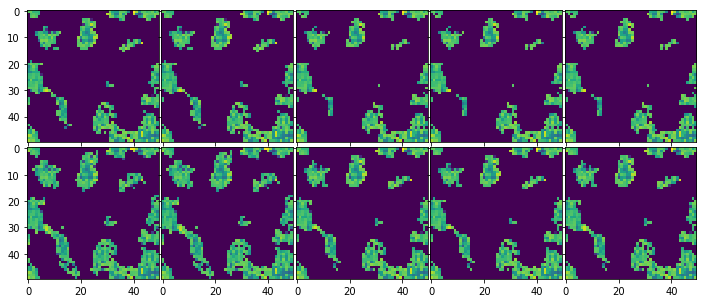

In [10]:
fig, ax = plt.subplots(chain.samples.shape[0], chain.samples.iteration, figsize=(12,5), sharex=True, sharey=True,
                      gridspec_kw={"hspace":0.02, 'wspace':0.02})

bt_slices = blobs['brightness_temp']

for i in range(chain.samples.iteration):
    for j in range(chain.samples.shape[0]): # n walkers
        ax[j,i].imshow(bt_slices[i,j])

### Storage in the Likelihood

To store arbitrary data in the ``Likelihood`` components, a dedicated ``store()`` method exists. To modify what is stored on each iteration, this method should be overwritten. The ``store`` method takes two arguments: ``model`` and ``storage``. The first is exactly the output of the ``simulate`` method of the ``Likelihood``. It is usually either a dictionary of quantities or a list of such dictionaries. The latter is the storage container which will be internally accessed to write out the quantities. This just needs to be updated with any quantity of interest. For example, let's imagine the built-in ``Likelihood1DPowerLightcone`` had no defined storage method, and we wanted to store *everything* in its model (which currently consists of ``k`` and ``delta``). We would do the following:

In [ ]:
class MyLCModule(core.CoreLightConeModule):
    def store(self, model, storage):
        for i, m in enumerate(model):
            storage.update({k + "_%s" %i : v for k, v in m.items()})

(this is, of course, the actual definition of the method in the source code). The ``blobs`` in the stored chain will now include the entries ``k`` and ``delta`` for each iteration of the chain. 

## How to add thermal noise to observations/mocks?

By default, both the coeval and lightcone likelihoods provided in 21CMMC do not include any thermal noise or sample variance. The only noise used by default is the modelling uncertainty. One way to add noise is to subclass an existing likelihood and over-write the ``computeLikelihood`` method, which can then be implemented with artbirary noise characteristics. We urge this point because 21CMMC is written to be *extensible* in this manner.

However, there is an easier way to add thermal-like noise to the two basic likelihoods provided in 21CMMC. Both contain a ``noisefile`` argument. This should be an existing file, in a numpy ``.npz`` format, with *at least* the arrays "ks" and "errs" defined within it. **OR**, it can be a list of such files, one for each coeval box or redshift chunk. This format is precisely what is written by ``21cmSense``, and so that can be natively used to compute the noise characteristics. However, we stress that any code that produces noise characteristics can be used, and the output simply reformatted into this simple format. 

If no such file is provided, the likelihood will assume that no special noise characteristics are being used. There is one caveat to this. If ``simulate=True``, and a ``define_noise`` method has been defined on the class, then this will be used to produce the noise properties on-the-fly. It must produce a list of dictionaries, each of which contains the arrays "ks" and "errs", as above, unless the derived class also over-writes the ``_write_noise`` method and the ``computeLikelihood`` method which use this data structure. If a noisefile *is* provided but does not exist, and the noise has been simulated in this way, it will instead be *written* to the provided file. 

Finally, if for some reason it is not possible to re-format your noise data, you can subclass the likelihood and overwrite the ``_read_noise`` method. This method should iterate through a list of files, and return a list of dicts containing the arrays "ks" and "errs".

As an example of using a noise file in the default manner:

In [6]:
core = mcmc.CoreCoevalModule(
    redshift = 7.0,
    user_params = {"HII_DIM":40, "BOX_LEN":80.0}
)

likelihood = mcmc.Likelihood1DPowerCoeval(
    noisefile = "hera127.drift_mod_0.135.npz", # File produced with 21cmSense
    simulate=True
)

In [8]:
mcmc.run_mcmc(
    core, likelihood, 
    params = {"HII_EFF_FACTOR":[30,20,40,3]},
    datadir='.', model_name='a_noise_model',
    sampleIterations = 10,
    burninIterations = 0,
    walkersRatio = 2, 
    log_level_stream = logging.INFO,
    continue_sampling=False
);

Initializing init and perturb boxes for the entire chain...

2018-09-03 12:12:42,279 INFO:Using CosmoHammer 0.6.1
2018-09-03 12:12:42,279 INFO:Using emcee 2.2.1
2018-09-03 12:12:42,283 INFO:all burnin iterations already completed
2018-09-03 12:12:42,285 INFO:Sampler: <class 'py21cmmc.mcmc.cosmoHammer.CosmoHammerSampler.CosmoHammerSampler'>
configuration: 
  Params: [30]
  Burnin iterations: 0
  Samples iterations: 10
  Walkers ratio: 2
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.mcmc.cosmoHammer.storage.HDFStorageUtil object at 0x7fe137d044a8>
likelihoodComputationChain: 
Core Modules: 
  CoreCoevalModule
Likelihood Modules: 
  Likelihood1DPowerCoeval

2018-09-03 12:12:42,286 INFO:start sampling after burn in


 done.
['burnin', 'sample_0']


2018-09-03 12:12:46,359 INFO:Iteration finished:10
2018-09-03 12:12:46,359 INFO:sampling done! Took: 4.0724s
2018-09-03 12:12:46,360 INFO:Mean acceptance fraction:0.4


## How does 21CMMC deal with parameters outside their range?

The default behaviour of ``cosmoHammer`` is to immediately return ``-np.inf`` if the sample parameters on a given iteration/walker are outside their bounds (bounds are specified by the ``params`` argument to ``run_mcmc``). A log-likelihood of ``-inf`` means that the likelihood is zero, and the sampler will not accept that position. This is completely self-consistent and is the recommended procedure in ``emcee`` (on which ``cosmoHammer`` is based). 

However, in ``21CMMC``, this can lead to significant inefficiencies due to load balancing. If a process returns instantly, but the MCMC step blocks until all walkers are finished, then that particular processor/thread is essentially idle, and the overall efficiency goes down.

To circumvent this, in ``21CMMC`` we over-load the ``emcee.EnsembleSampler`` class, so that new new samples are vetted _before_ passing them to the likelihood function. If a new sample position is outside the range, it is independently re-sampled until it is within range. There is a failsafe ``max_attempts`` parameter which will shut down this loop of resampling if no suitable parameters can be found (by default it is set to 100). This means that all processes will be running close to 100% of the time, increasing the efficiency of the sampling.

## What parameter ranges should I use?

## My run crashed with BrokenProcessPool exception, what is that?

The ``BrokenProcessPool`` exception is a special exception that catches anything that goes _really_ wrong in the underlying C-code -- like a segfault. When this happens, it's basically impossible for Python to know what really went wrong, since these errors are really errors in the compiled code itself and do not conform to standard exceptions. However, this exception gives Python a way to report to you _something_ about the error. 

We've overloaded the ``emcee`` sampler to know about this error and to report about which parameters were being evaluated at the time that something broke. It cannot tell which parameters were actually at fault, but if you test each one of them in turn, you may be able to identify the problem.

Using this information in tandem with DEBUG mode can be particularly helpful.

## My run crashed and I don't know why, can I debug?

There are several ways to debug the runtime behaviour of 21CMMC. While for developers an explicit DEBUG mode is posible, as a user it is much more likely that you will just want to inspect the logging output in order to identify a potential problem. We highly recommend sending any errors through to the development team via github (https://github.com/BradGreig/Hybrid21cm/issues/) and including this logging ouput. So, how to get the logging output?

There are actually three different logs running on any given MCMC run:

1. The cosmoHammer log. This gets written to the ``<filePrefix>.log`` file, but can also be written to stderr/stdout. It contains information about the computation chain, and keeps a running report of the progress of the sampler. To set which level of logging it reports at, you can specify either/both of ``logLevel`` and ``log_level_stream`` in ``run_mcmc``. The first changes the level of the file, and the latter the output to screen. It can be set to a string identifier such "DEBUG", or an integer, where the _lower_ the integer the more will be printed. See https://docs.python.org/3/library/logging.html#logging-levels for details. A good idea is to set to "DEBUG" when debugging, clearly.
2. The 21CMMC log. This is the log of the internal wrapper functions for 21cmFAST, and also the Core's and Likelihoods. By default, it has only one handler (it writes to screen). Much more information will be printed out if this is set to "DEBUG". Note that these logs can be manipulated using the standard python logging module. However, as a convenience, to just change the level (from its default of WARNING) in the MCMC, you can pass ``log_level_21CMMC`` to ``run_mcmc``.
3. The C-code logs. These logs are printed to stderr. By default, the level here is WARNING. However, due to extensive debugging developer-side, there is a lot of information that is logged if the level is DEBUG (or even SUPER_DEBUG or ULTRA_DEBUG!). To change these levels, you need to re-install the package, using the environment variable ``LOG_LEVEL=DEBUG``. 

Our advice is to set all of these levels to DEBUG (and maybe SUPER_DEBUG) for the C-code, if your code is crashing there) when something goes awry. 

## Can I get a history of all parameters trialed in the MCMC?

While the sampler object returned by ``run_mcmc`` will contain a full chain of parameter samples from your posterior, it is sometimes helpful to keep a running history of _all_ parameters that were tried, whether they were accepted or not. At this time, we don't offer a simple function for doing this, but it can be reasonably easily achieved by inspecting the logs. If you set ``log_level_21CMMC`` to ``INFO`` or less, then the logs will contain entries of ``New Positions: <params>`` for each set of parameters trialed. If you have redirected your log to a file, you can get a list of trialed parameters using something like the following script:

In [ ]:
import json
params = []

with open("logfile") as f:
    for line in f:
        if "New Positions:" in line:
            s = line.split(":")[-1]
            params += json.loads(s)

## Can I interactively explore my Likelihood after running MCMC?

Sometimes, especially when first building a new likelihood, you may run an MCMC chain, and realise that it doesn't quite look like what you expect. The easiest way to explore what may have gone wrong would be to re-create the exact same ``LikelihoodComputationChain`` and interactively produce the likelihood calculations for a few parameters yourself. 

Fortunately, that exact behaviour is provided by the output file "<model name>.LCC.yml". Using the ``yaml`` module built in to ``21CMMC`` (which has a few extra representers/constructors than the default one from ``pyyaml``) you can literally read this file in and it will be the entire ``LikelihoodComputationChain`` object, which you can explicitly call with new parameters, or otherwise investigate. 
    
One word of caution for those writing their own Cores/Likelihoods: the YAML loader/dumper is _slow_ and is not intended for dealing with large datasets. For this reason, cores and likelihoods work best when their attributes are small in size (eg. the CoreCoevalModule does not save any of simulated data -- it merely saves the parameters so that it can be instantly read in from cache at any time). 

To partially mitigate this, the YAML file that is written when calling ``run_mcmc`` contains the _pre-setup_ class, which should fully define the chain, but often does not have much of the data loaded in. THis choice however means that to use the chain interactively after it is read in, you are required to manually call ``setup()``. Alternatively, one can use the convenience function in ``analyse.py`` to read in the file.

Note that this ``.LCC.yml`` file is internally used to ensure that when you try to "continue" running a chain that all of the parameters exactly line up so that nothing inconsistent happens. It is saved _before_ running the MCMC, so none of the actual chain parameters are saved into it.

YAML files are meant to be (mostly) human-readable, so you can also just look at it to determine what your setup was long after running it.

An example of how to read in the file interactively:

In [ ]:
from py21cmmc import yaml

with open("MyBigModel.LCC.yml") as f:
    lcc = yaml.load(f)
    
# Call setup to set up the chain properly (this adds data/noise etc.)
lcc.setup()

lnl, blobs = lcc(<parameters>)

core_module = lcc.getCoreModules()[0]
core_module.do_something()

Alternatively, one could do the following:

In [ ]:
from py21cmmc.analyse import load_primitive_chain

lcc = load_primitive_chain("MyBigModel")

# No set-up required.

lnl, blobs = lcc(<parameters>)